Ema's Quantum Computer

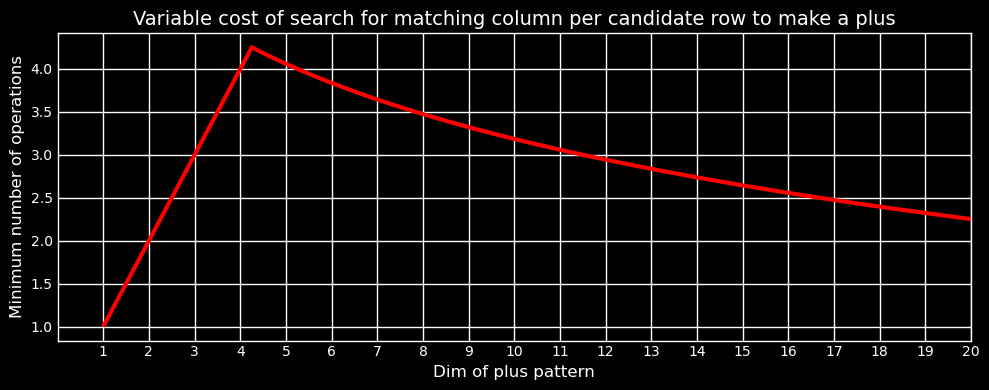

In [4]:

from colour import Color
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import log2

plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.style.use('dark_background')

n = 1000

def f(x, n):
    x = np.minimum(x, np.log2(n / (x + 1)))  # Use np.minimum for element-wise minimum
    return x

plt.xlabel('Dim of plus pattern', fontsize='12')
plt.ylabel('Minimum number of operations', fontsize='12')
plt.title(f'Variable cost of search for matching column per candidate row to make a plus', fontsize='14')

n = 100  # Example value for n
x = np.linspace(1, 30, 100_000)

plt.plot(x, f(x, n), color=Color('red').get_hex_l(), linewidth=3)

ax = plt.gca()
ax.set_xlim([0, 20])
ax.set_xticks(list(i for i in range(1,21)))

plt.show()


In [58]:
def populate(grid)->dict:
    d = {}
    dflat = {}
    def populate2():
        if L not in d:
            d[L] = {}
        inner_dict = d[L]
        if rownum not in inner_dict:
            inner_dict[rownum] = []
        inner_dict[rownum].append((right,L))
    def populate_flat():
        if rownum not in dflat:
            dflat[rownum] = []
        dflat[rownum].append((right,L))
    for rownum,row in enumerate(grid):
        # print(f'entering row {rownum}, {row}')
        start = False
        starti = -1
        for i,val in enumerate(row):
            if val == 'G':
                if not start:
                    start = True
                    starti = i
            else:
                if start:    # here we find our end point 
                    start = False
                    L = i - starti
                    right = i - 1
                    # print(f'L is {L}, right is {right}')
                    populate2()
        else:
            if start:
                L = i - starti + 1
                right = i
                # print(f'L is {L}, right is {right}')
                populate2()
    return d,dflat

In [59]:
def populate_2d_dict(d1)->dict:
    '''
    Helperfunction that creates a separate 2d_dict that points to 
    the same lists as populate_2d_dict with swapped inner and outer keys
    '''
    d2 = {}
    for L, d in d1.items():
        for row,inner_dict in d.items():
            if row not in d2:
                d2[row] = {}
            d2[row][L] = d1[L][row]
    return d2

In [68]:
def print_2d_dict(d,outerkey='key1',innerkey='key2'):
    for key,inner_dict in d.items():
        print(outerkey,key)
        for row,rightlist in inner_dict.items():
            print(innerkey,row,'list',rightlist)
    print('*******************')

In [74]:
def print_1d_dict(d,title = '1d dict'):
    print('printing', title)
    for key, value in d.items():
        print(key, value)
    print('*******************')

In [75]:
def populate_rowdict(index_d)->dict:
    '''
    Helper function that stores the iteratively merged sorted lists
    for each row
    Takes as input populate_2d_dict output
    '''
    d = {}
    for row in index_d:
        d[row] = []
    return d

In [76]:
def populate_rowdict_sorted_keys(dict_2d):
    '''
    Helper function for populate_2d_dict
    takes in output of populate_2d_dict
    stores the sorted list of remaining un-merged keys
    Pop from lists in this dictionary to get the next key 
    to merge into populate_rowdict's dict
    '''
    d = {}
    for row,inner_dict in dict_2d.items():
        d[row] = sorted(inner_dict.keys()) # keys would be L from the dict_2d that has row -> L -> [right,...]
    return d

In [113]:
from heapq import merge
def merge_into_rowdict(L, rownum, irowdict_2d, rowdict, rowdict_keys):    # L, rownumber, irow or icol, rowdict, rowdict keys
    '''
    Function to merge from row to rowdict using keys from rowdict_index
    '''
    inner_dict_L_rightlist = irowdict_2d[rownum]    #at inner rowdict to get merge items
    L_sorted = rowdict_keys[rownum]    # get the sorted keys remaining
    print('merging inside with keys: ',L_sorted)
    while L_sorted and L < L_sorted[-1]:
        key = L_sorted.pop()
        print('inside merge_into_rowdict, key = ',key)
        rowdict[rownum] = list(merge(rowdict[rownum], inner_dict_L_rightlist[key])) #merge two lists of (x,y) tuples
        print(rowdict[rownum], 'merge output')
        del inner_dict_L_rightlist[key]    # this deletes the key reference in the inner dict 

        

In [120]:
from bisect import bisect_left as bs
from collections import deque
from heapq import merge
def twoPluses(grid):
    n = len(grid)
    m = len(grid[0])
    dplus = {}

    drow, drowflat = populate(grid)
    dcol, dcolflat = populate(zip(*grid))

    irow = populate_2d_dict(drow)
    icol = populate_2d_dict(dcol)

    merge_rows = populate_rowdict(irow)
    merge_cols = populate_rowdict(icol)

    merge_rows_keys = populate_rowdict_sorted_keys(irow)
    merge_cols_keys = populate_rowdict_sorted_keys(icol)

    #find each centroid that is a valid + and enter into dict
    def search_at_L(L, dplus, d_in, i_in, merge_dict, merge_dict_keys):
        def search_in(L, fixed_column):
            merge_into_rowdict(L, fixed_column, i_in, merge_dict, merge_dict_keys)

                

        print('searching at L: ', L)
        if L not in d_in:
            print('no L')
            return
        inner_dict = d_in[L]    # inner dict that contains key row and value right
        if L % 2 == 0:    # necessary because even lengths are not valid +, just encoded this way for global simplicity
            print('adjusting L')
            adjustment = (-1,0)
            L -= 1
        else:
            adjustment = (0,)
        # nested for loop over every right - runtime is linear because of key access and constant bounds for loops 1 and 3
        for row, rightlist in inner_dict.items():
            for right in rightlist:
                for adj in adjustment:
                    # print(right,adj,right+adj)
                    right_temp = right[0] + adj
                    column = right_temp - L//2
                    print(f'row {row} rightlist {rightlist} right {right_temp} column {column}')
                    search_in(L, column)
                    # centroid at row,column now search in d_out for a match where column is fixed and right is variable on row

    # print('printing dictionaries')
    # print_2d_dict(drow,'L','row')
    # print_2d_dict(irow,'row','L')
    # print_1d_dict(merge_rows, 'merge rows')  
    # print_1d_dict(merge_rows_keys,'keys')

    # print('doing dcol')
    # print_2d_dict(dcol,'L','col')
    # print_2d_dict(icol,'col','L')
    # print_1d_dict(merge_cols, 'merge rows')  
    # print_1d_dict(merge_cols_keys,'keys')
    
    max1 = 0
    max2 = 0
    longest = sorted(list(drow.keys() | dcol.keys()))
    row_keys = sorted(list(drow.keys()))
    col_keys = sorted(list(dcol.keys()))

    # rqueue = deque([row_keys.pop()])
    # cqueue = deque([col_keys.pop()]) # Using deque because less memory overhead

    # print(rqueue,cqueue)
    while longest:    # for each L from highest
        L = longest.pop()
        print('L decremented to: ', L)
        print('search at rows')
        search_at_L(L,dplus, drow, icol, merge_cols, merge_cols_keys)    # search drow[L] for all rights of length L
        print('search_at_cols')
        search_at_L(L,dplus, dcol, irow, merge_rows, merge_rows_keys)
        print('**************************')
            
    print_1d_dict(merge_cols, 'merge cols')  
    print_1d_dict(merge_rows, 'merge rows')  


In [121]:
twoPluses(grid)

L decremented to:  6
search at rows
searching at L:  6
adjusting L
row 0 rightlist [(5, 6)] right 4 column 2
merging inside with keys:  [1]
row 0 rightlist [(5, 6)] right 5 column 3
merging inside with keys:  [1]
row 2 rightlist [(5, 6)] right 4 column 2
merging inside with keys:  [1]
row 2 rightlist [(5, 6)] right 5 column 3
merging inside with keys:  [1]
row 4 rightlist [(5, 6)] right 4 column 2
merging inside with keys:  [1]
row 4 rightlist [(5, 6)] right 5 column 3
merging inside with keys:  [1]
search_at_cols
searching at L:  6
no L
**************************
L decremented to:  5
search at rows
searching at L:  5
no L
search_at_cols
searching at L:  5
row 0 rightlist [(4, 5)] right 4 column 2
merging inside with keys:  [6]
inside merge_into_rowdict, key =  6
[(5, 6)] merge output
row 4 rightlist [(4, 5)] right 4 column 2
merging inside with keys:  []
**************************
L decremented to:  3
search at rows
searching at L:  3
no L
search_at_cols
searching at L:  3
row 1 right

In [15]:
grid = [
'GGGGGG',
'GBBBGB',
'GGGGGG',
'GGBBGB',
'GGGGGG',
]

In [28]:
import timeit

list_time = timeit.timeit('["a", "b", "c", "d"]', number=1000000)
tuple_time = timeit.timeit('("a", "b", "c", "d")', number=1000000)

print(f"List creation time: {list_time}")
print(f"Tuple creation time: {tuple_time}")


List creation time: 0.04958500000066124
Tuple creation time: 0.01015340001322329
